In [11]:
import torch
import datasets
import os
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
from utils import plot_adult_results
from sklearn.metrics import accuracy_score, mean_squared_error
from torch import nn
from main import test 
from model import Predictor, ImagePredictor, Adversary

In [12]:
ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = os.path.join(ROOT_DIR, "saved_models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intro statement of problem

Embeddings are a powerful mechanism for projecting a discrete variable (e.g. words, locales, urls) into a multi-dimensional real valued space.  Several strong methods have been developed for learning embeddings.  One example is the [Skipgram](http://www.cs.brandeis.edu/~marc/misc/proceedings/lrec-2006/pdf/357_pdf.pdf) algorithm.  In that algorithm the surrounding context is used to predict the presence of a word.  Unfortunately, much real world textual data has subtle bias that machine learning algorithms will implicitly include in the embeddings created from that data.  This bias can be illustrated by performing a word analogy task using the learned embeddings.

It is worth noting that the usages of terms like _fair_ and _bias_ are used in this notebook in the context of a particular definition of fairness sometimes referred to as "Demographic Parity" or "Equality of Outcomes" ([Hardt et. al 2016](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)).  This definition of fairness effectively says that any relationship at all between a variable of interest and a _protected variable_ is an example of unwanted bias.  Other definitions of fairness such as "Equality of Odds" can be employed when there is believed to be some form of proper relationship between the variable of interest and the protected variable.  However, all uses of _fair_ and _bias_ here should be interpreted in the context of "Demographic Parity".

## Adversarial Networks for Bias Mitigation

The method presented here for removing some of the bias from embeddings is based on the idea that those embeddings are intended to be used to predict some outcome $Y$ based on an input $X$ but that outcome should, in a fair world, be completely unrelated to some protected variable $Z$.  If that were the case then knowing $Y$ would not help you predict $Z$ any better than chance. The first attempts to predict $Y$ using $X$ as input.  The second attempts to use the predicted value of $Y$ to predict $Z$.  We can see the Figure 1 of [the paper](https://arxiv.org/pdf/1801.07593.pdf).

However, simply training the weights in W based on $\nabla_WL_1$ and the weights in $U$ based on $\nabla_UL_2$ won’t actually achieve an unbiased model.  In order to do that we need to incorporate into $W$’s update function the concept that $U$ should be no better than chance at predicting $Z$.  The way that we can achieve that is analogous to how Generative Adversarial Networks (GANs) ([Goodfellow et al. 2014](http://papers.nips.cc/paper/5423-generative-adversarial-nets)) train their generators.

In addition to $\nabla_WL_1$ we incorporate the negation of $\nabla_WL_2$ into $W$’s update function.  However, it’s possible that $\nabla_WL_1$ is changing $W$ in a way which will improve accuracy by using the biased information we are trying to protect.  In order to avoid that you also incorporate a term which removes that component of $\nabla_WL_1$ by projecting it onto $\nabla_WL_2$.  Once we’ve incorporated those two terms, the update function for $W$ becomes:


$\nabla_WL_1-proj_{(\nabla_WL_2)}\nabla_WL_1 - \alpha\nabla_WL_2$


# Results UCI Adult Dataset

we trained 30 different predictors without debiasing (seed 1 - 30) and 30 different predictors with debiasing (seed 1 - 30) and averaged the results of those models（In github).In this notebook I only show the result for a single model trained with the seed set to 15.
The models where trained with the following settings: <br>
- Without debias
> Epochs: 10 <br>
> Batch size: 128 <br>
> Predictor learning rate: 0.1 <br>

- With debias (Faithful implementation)
> Epochs: 30 <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.01 <br> 
> Adversary learning rate: 0.001 <br>
> Alpha: $\sqrt t$, where $t$ is the training step <br> 
> Decays predictor learning rate every training step $t$ by $\eta \leftarrow \eta \cdot 1/t$


- With debias (Refined implementation)
> Epochs: 15 <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.001 <br> 
> Adversary learning rate: 0.001 <br>
> Alpha: 0.3 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset 

In [13]:
__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='adult')

sex      income
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
Name: income, dtype: int64
sex      income 
 Female   <=50K.    4831
          >50K.      590
 Male     <=50K.    7604
          >50K.     3256
Name: income, dtype: int64


### Load models 


Filenames of the saved models

In [14]:
pred_biased_filename = "pred_debiased_False_adult_seed_15" 
pred_debiased_f_filename = "pred_debiased_True_faithful_adult_seed_15"
pred_debiased_r_filename = "pred_debiased_True_refined_adult_seed_15"

In [15]:
input_dim = next(iter(dataloader_test))[0].shape[1]

# Load the predictor trained without debiasing
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the predictor trained with debiasing (faithful implementation)
predictor_debiased_f = Predictor(input_dim).to(DEVICE)
predictor_debiased_f.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_f_filename), map_location=DEVICE))
predictor_debiased_f.eval();

# Load the predictor trained with debiasing (refined implementation)
predictor_debiased_r = Predictor(input_dim).to(DEVICE)
predictor_debiased_r.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_r_filename), map_location=DEVICE))
predictor_debiased_r.eval();

### Results on test set

In [16]:
def plot_confusion_matrix(confusion_matrix, plot_title="", ax=None):
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 14}, fmt='g', cbar=False, cmap="Blues", ax = ax)
    ax.set_title(plot_title, fontsize=13); 
    ax.xaxis.set_ticklabels(['Pred 0', 'Pred 1'], fontsize=12); 
    ax.yaxis.set_ticklabels(['True 0', 'True 1'], fontsize=12);
    
def plot_confusion_matrices(confusion_matrix_male, confusion_matrix_female, plot_title=""):
    fig, axs = plt.subplots(1, 2, figsize=(6,2))
    plot_confusion_matrix(confusion_matrix_male, plot_title="Male", ax=axs[0])
    plot_confusion_matrix(confusion_matrix_female, plot_title="Female", ax=axs[1])
    fig.suptitle(plot_title, fontsize=15)
    plt.tight_layout()
    plt.show()
    
def print_results(accuracy, mutual_info, neg_fpr, pos_fpr, neg_fnr, pos_fnr, model_type=""):
    print("-------------------------------------------------------------------")
    print("RESULTS %s \n"%(model_type.upper()))
    print("Test accuracy predictor: {:.5f}".format(accuracy))
    print("Mutual information I(Z; Y_hat | Y): {:.5f}\n".format(mutual_info))
    print("False Postive Rates (FPR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fpr, pos_fpr))
    print("False Negative Rates (FNR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fnr, pos_fnr))
    print()
    print("Absolute difference FPR between Female vs. Male: {:.5f}".format(abs(neg_fpr - pos_fpr)))
    print("Absolute difference FNR between Female vs. Male: {:.5f}".format(abs(neg_fnr - pos_fnr)))
    print("-------------------------------------------------------------------")

In [17]:
# Results predictor trained without debiasing
accuracy_b, neg_confusion_mat_b, neg_fpr_b, neg_fnr_b, pos_confusion_mat_b, pos_fpr_b, pos_fnr_b, mutual_info_b = test(dataloader_test, 
                                                                                                           predictor = predictor_biased, 
                                                                                                           adversary = None, 
                                                                                                           criterion = nn.BCELoss(), 
                                                                                                           metric = accuracy_score, 
                                                                                                           device = DEVICE, 
                                                                                                           dataset_name = 'adult', 
                                                                                                           show_logs = False)

# Results predictor trained with debiasing (faithful implementation)
accuracy_dbf, neg_confusion_mat_dbf, neg_fpr_dbf, neg_fnr_dbf, pos_confusion_mat_dbf, pos_fpr_dbf, pos_fnr_dbf, mutual_info_dbf = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased_f, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           dataset_name = 'adult', 
                                                                                                                           show_logs = False)
# Results predictor trained with debiasing (refined implementation)
accuracy_dbr, neg_confusion_mat_dbr, neg_fpr_dbr, neg_fnr_dbr, pos_confusion_mat_dbr, pos_fpr_dbr, pos_fnr_dbr, mutual_info_dbr = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased_r, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           dataset_name = 'adult', 
                                                                                                                           show_logs = False)

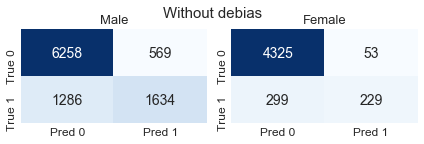

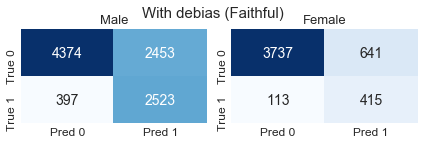

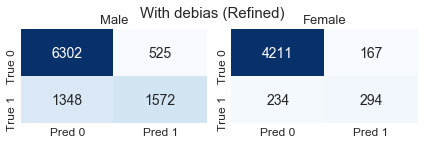

In [18]:
plot_confusion_matrices(pos_confusion_mat_b, neg_confusion_mat_b, plot_title="Without debias")
plot_confusion_matrices(pos_confusion_mat_dbf, neg_confusion_mat_dbf, plot_title="With debias (Faithful)")
plot_confusion_matrices(pos_confusion_mat_dbr, neg_confusion_mat_dbr, plot_title="With debias (Refined)")

#### Shown are the confusion matrices of the predictor trained with and without debiasing.

In [19]:
print_results(accuracy_b, mutual_info_b, neg_fpr_b, pos_fpr_b, neg_fnr_b, pos_fnr_b, model_type="Without debias")
print_results(accuracy_dbf, mutual_info_dbf, neg_fpr_dbf, pos_fpr_dbf, neg_fnr_dbf, pos_fnr_dbf, model_type="With debias (Faithful)")
print_results(accuracy_dbr, mutual_info_dbr, neg_fpr_dbr, pos_fpr_dbr, neg_fnr_dbr, pos_fnr_dbr, model_type="With debias (Refined)")

-------------------------------------------------------------------
RESULTS WITHOUT DEBIAS 

Test accuracy predictor: 0.84938
Mutual information I(Z; Y_hat | Y): 0.01692

False Postive Rates (FPR):
      Female: 0.01211 || Male: 0.08335
False Negative Rates (FNR):
      Female: 0.56629 || Male: 0.44041

Absolute difference FPR between Female vs. Male: 0.07124
Absolute difference FNR between Female vs. Male: 0.12588
-------------------------------------------------------------------
-------------------------------------------------------------------
RESULTS WITH DEBIAS (FAITHFUL) 

Test accuracy predictor: 0.75404
Mutual information I(Z; Y_hat | Y): 0.03261

False Postive Rates (FPR):
      Female: 0.14641 || Male: 0.35931
False Negative Rates (FNR):
      Female: 0.21402 || Male: 0.13596

Absolute difference FPR between Female vs. Male: 0.21289
Absolute difference FNR between Female vs. Male: 0.07806
-------------------------------------------------------------------
------------------

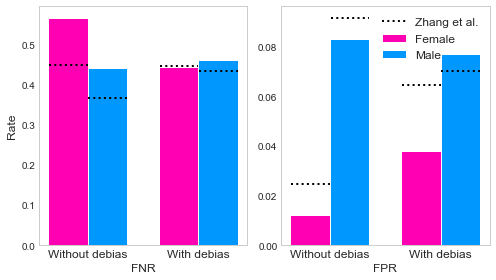

In [20]:
# Plots FNR and FPR rates for without debias and with debias (refined) 
plot_adult_results([neg_fnr_b], [pos_fnr_b], [neg_fpr_b], [pos_fpr_b], 
                   [neg_fnr_dbr], [pos_fnr_dbr], [neg_fpr_dbr], [pos_fpr_dbr])

#### Shown are the FNR and FPR for females and males both with and without debiasing.